# IHLT Project

---

## Introduction

In this project, we implement approaches to detect paraphrases using sentence similarity metrics by exploring:

- **Lexical features alone**
- **Syntactic features alone**
- **Combination of lexical, syntactic, and semantic features**

We use **XGBoost** as our machine learning model and cite properly where each technique is derived from, based on the curated compilation from SemEval 2012 papers.

### Motivation

Understanding semantic similarity between sentences is essential for various NLP tasks, such as machine translation, summarization, and question answering. The SemEval 2012 Task 6 provided a benchmark for evaluating semantic textual similarity methods.

### Features Overview

Based on insights from SemEval 2012 Task 6 papers ([2], [4], [8]), we implement the following features:

- **Lexical Features**  
  Derived from methods used in SemEval 2012 papers [2], [4], [8].
  - Jaccard similarity
  - Normalized edit distance
  - Cosine similarity using TF-IDF vectors
  - Word n-gram overlap
  - Character n-gram overlap
  - Token overlap ratio
  - Longest common subsequence
  - String matching metrics
  - Word order similarity
  - Normalized difference in sentence lengths

- **Syntactic Features**  
  Derived from methods in SemEval 2012 papers [2], [3].
  - POS tag overlap ratio
  - POS tag sequence similarity
  - Dependency relation overlap
  - Grammatical relations overlap

- **Semantic Features**  
  Derived from methods in SemEval 2012 papers [2], [8].
  - WordNet-based similarity metrics
  - Named entity overlap
  - Semantic word overlap using synonyms

---

The current jupyter notebook 

python 3.10.12 as in colab

## 1. Data Preparation

### 1.1 Import Libraries

In [ ]:
# basic
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

# parallelise execution
from concurrent.futures import ThreadPoolExecutor, as_completed

# nlp
import nltk
import spacy

# nltk downloads
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

# our scripts
from scripts.data_loader import load_data
from scripts.feature_extraction import FeatureExtractor

### 1.2 Load Data

In [ ]:
# 2. Data Preparation

data_dir = 'data'  # Replace with your data directory path

# Load training data
train_data = load_data(data_dir, dataset_type='train')

# Load test data
test_data = load_data(data_dir, dataset_type='test')

# Check data format
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")


### 1.3 Explore Data

In [ ]:
pd.DataFrame(test_data)

## 2. Feature Extraction

To avoid recalculation, we extract all features at once and then filter before training!

In [ ]:
extractor = FeatureExtractor()

In [8]:
train_df  = extractor.extract_features_parallel(train_data)

Extracting Features:  17%|█▋        | 374/2234 [01:15<09:32,  3.25it/s]/root/anaconda3/envs/ihlt/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
Extracting Features:  19%|█▉        | 425/2234 [01:23<05:58,  5.05it/s]/root/anaconda3/envs/ihlt/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
Extracting Features:  69%|██████▉   | 1539/2234 [03:36<04:58,  2.32it/s]/root/anaconda3/envs/ihlt/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
Extracting Features:  71%|███████   | 1583/2234 [03:53<06:08,  1.77it/s]/root/anaconda3/envs/ihlt/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:2

In [9]:
test_df = extractor.extract_features_parallel(test_data)

Extracting Features:  10%|█         | 325/3108 [01:04<05:55,  7.83it/s]/root/anaconda3/envs/ihlt/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
Extracting Features:  48%|████▊     | 1497/3108 [03:09<02:13, 12.07it/s]/root/anaconda3/envs/ihlt/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
Extracting Features:  49%|████▊     | 1514/3108 [03:10<02:05, 12.67it/s]/root/anaconda3/envs/ihlt/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
/root/anaconda3/envs/ihlt/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explaine

## 3. Experiments

### 3.1 Define feature sets

In [10]:
lexical_features_columns = [col for col in train_df.columns if col.startswith('lex_')]
syntactic_features_columns = [col for col in train_df.columns if col.startswith('syn_')]
semantic_features_columns = [col for col in train_df.columns if col.startswith('sem_')]

feature_sets = {
    'lexical': lexical_features_columns,
    'syntactic': syntactic_features_columns,
    'semantic': semantic_features_columns,
    'combined': lexical_features_columns + syntactic_features_columns + semantic_features_columns
}

### 3.2 Run Experiments

In [20]:
from scripts.experiments import run_experiment

for feature_set_name, feature_columns in feature_sets.items():
    print("="*80)
    print(f"Running experiments for feature set: {feature_set_name}")
    model, test_predictions_df, feature_importances = run_experiment(
        train_df,
        test_df.copy(),
        feature_columns,
        feature_set_name
    )

Running experiments for feature set: lexical
Cross-validation results for feature set 'lexical':
Fold 1: Pearson overall = 0.8234
    Dataset MSRpar: Pearson = 0.6049
    Dataset MSRvid: Pearson = 0.7459
    Dataset SMTeuroparl: Pearson = 0.7887

Fold 2: Pearson overall = 0.8537
    Dataset MSRpar: Pearson = 0.5481
    Dataset MSRvid: Pearson = 0.8262
    Dataset SMTeuroparl: Pearson = 0.6641

Fold 3: Pearson overall = 0.8148
    Dataset MSRpar: Pearson = 0.6606
    Dataset MSRvid: Pearson = 0.7631
    Dataset SMTeuroparl: Pearson = 0.7101

Fold 4: Pearson overall = 0.7892
    Dataset MSRpar: Pearson = 0.5084
    Dataset MSRvid: Pearson = 0.7798
    Dataset SMTeuroparl: Pearson = 0.4653

Fold 5: Pearson overall = 0.8742
    Dataset MSRpar: Pearson = 0.5191
    Dataset MSRvid: Pearson = 0.8846
    Dataset SMTeuroparl: Pearson = 0.5788

Test results for feature set 'lexical':
Overall Pearson correlation: 0.6973
    Dataset MSRpar: Pearson = 0.5852
    Dataset MSRvid: Pearson = 0.8178
   

### 3.3 Feature Importance

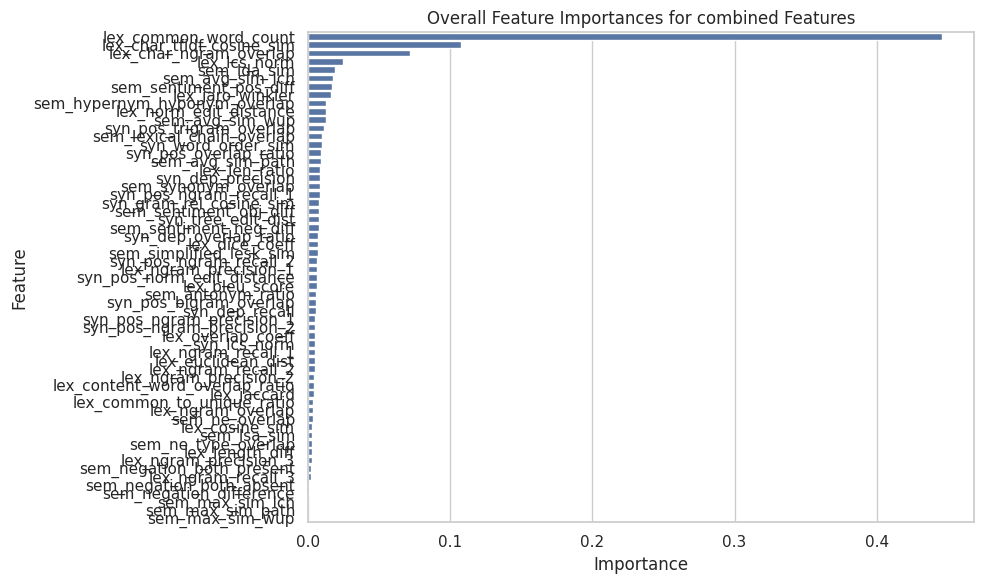

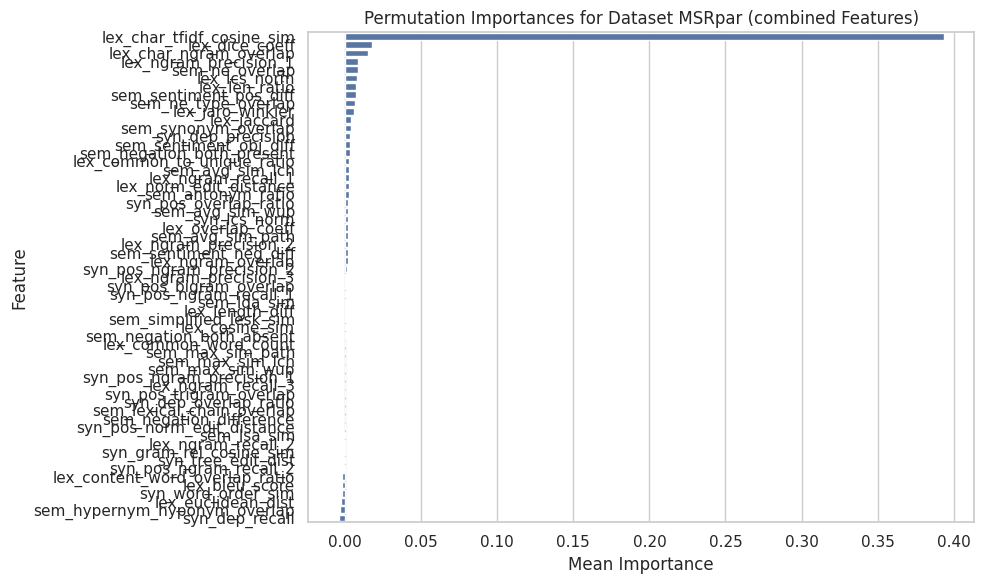

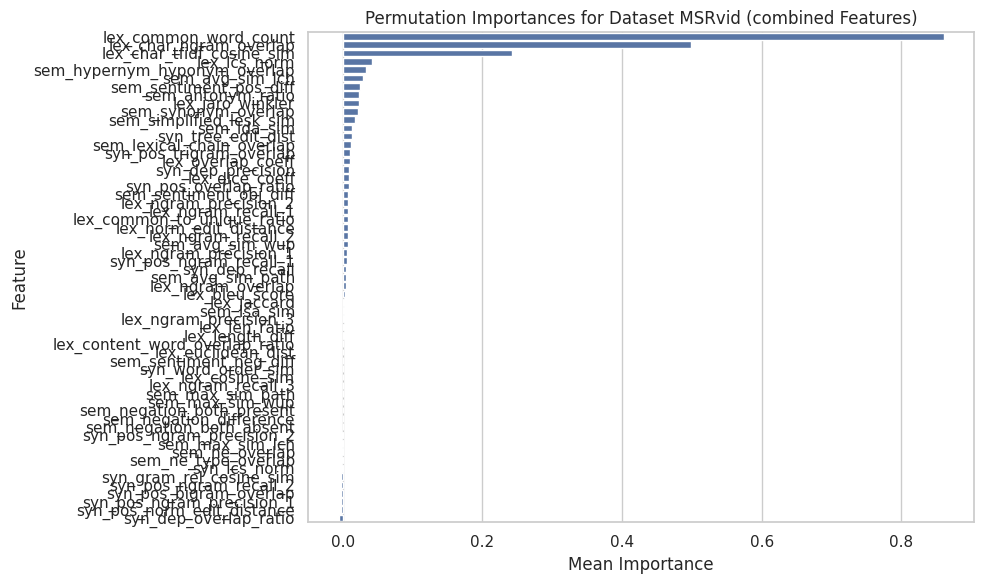

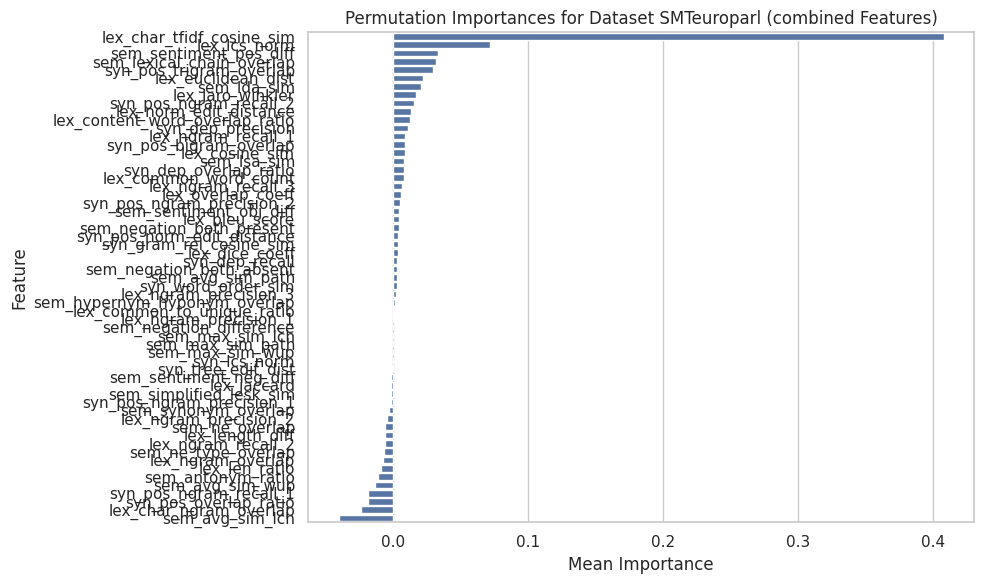

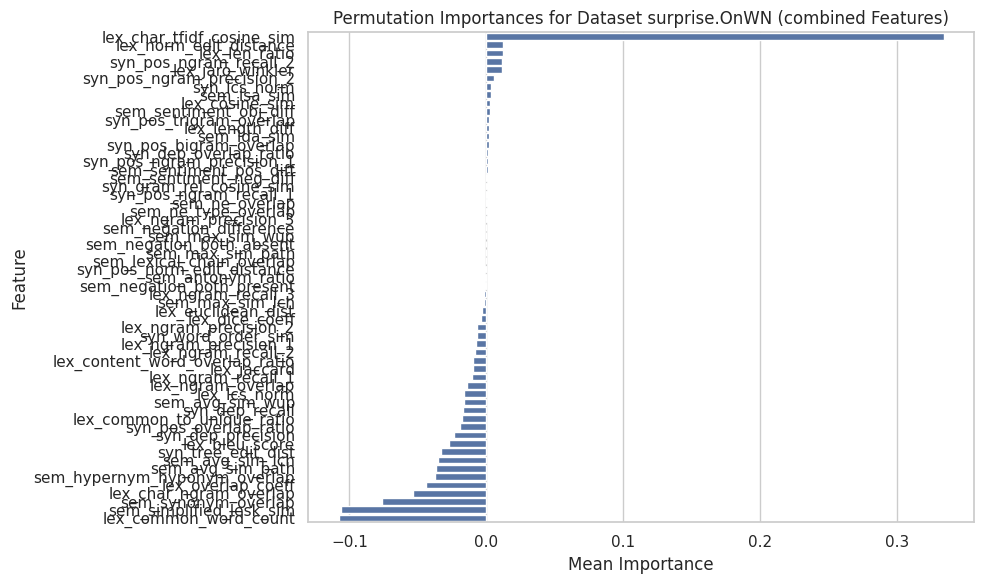

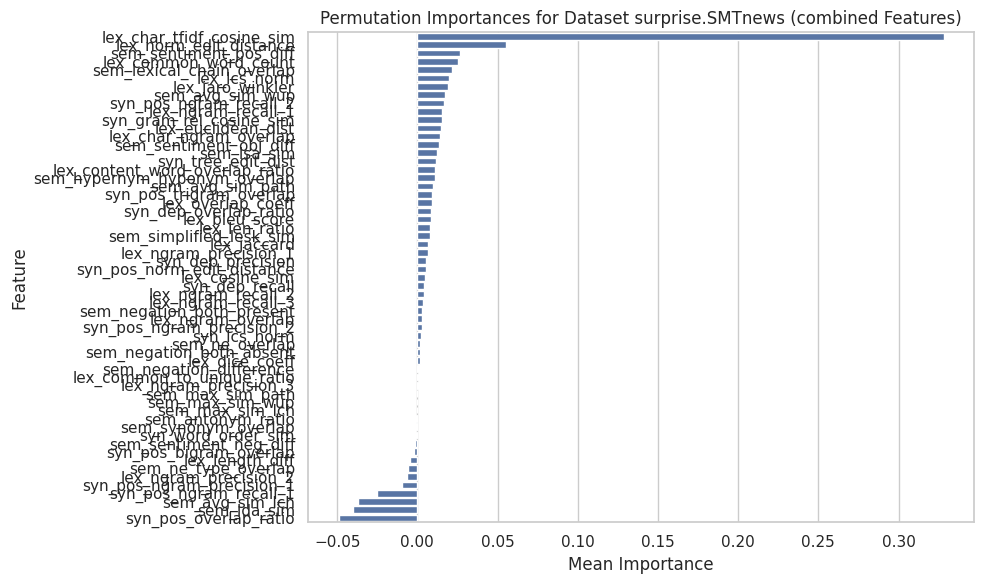

In [23]:
# Plot overall feature importances
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title(f"Overall Feature Importances for {feature_set_name} Features")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Feature importance per dataset in test data
datasets = test_predictions_df['dataset'].unique()
for dataset in datasets:
    df_dataset = test_predictions_df[test_predictions_df['dataset'] == dataset]
    X = df_dataset[feature_columns]
    y = df_dataset['score']

    # Compute permutation importances
    result = permutation_importance(
        model, X, y,
        scoring='neg_mean_squared_error',
        n_repeats=10,
        random_state=42
    )

    perm_importances = pd.Series(result.importances_mean, index=feature_columns)
    perm_importances = perm_importances.sort_values(ascending=False)

    # Plot permutation importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x=perm_importances.values, y=perm_importances.index)
    plt.title(f"Permutation Importances for Dataset {dataset} ({feature_set_name} Features)")
    plt.xlabel('Mean Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


**References for All Features:**

- **Word Overlap Measures (Jaccard similarity, Dice coefficient, Overlap coefficient):** Used by multiple teams in SemEval 2012 Task 6, including [Baer et al., 2012], [Glinos, 2012], and [Jimenez et al., 2012].

- **Edit Distance and String Similarity Measures:** Used by [Glinos, 2012] and [Jimenez et al., 2012].

- **TF-IDF Vector Similarity:** Employed by the UKP team [Baer et al., 2012] for computing cosine similarity using TF-IDF vectors.

- **Character N-gram Features:** Utilized by teams like [Baer et al., 2012] and [Jimenez et al., 2012].

- **BLEU Score:** Used by [Baer et al., 2012] as part of the feature set.

- **Content Word Overlap:** Considered by [Jimenez et al., 2012] in their similarity measures.

- **POS Tag Features:** Teams like [Baer et al., 2012] and [Glinos, 2012] used POS tag overlaps and distributions.

- **Dependency Relations and Tree Structures:** Explored by [Štajner et al., 2012] for syntactic similarity.

- **WordNet-based Semantic Features:** Used extensively by the UKP team [Baer et al., 2012] and the TakeLab team [Štajner et al., 2012], including synonym overlap, hypernym/hyponym overlap, and various similarity measures.

- **Named Entity Features:** Incorporated by [Baer et al., 2012].

- **Sentiment Analysis Features:** Included by teams like [Gupta et al., 2012] in their submissions.

- **Negation Handling:** Addressed by [Baer et al., 2012] to capture differences due to negation.

**Referenced Papers:**

- **[Baer et al., 2012]:**

  Baer, P., and Zesch, T. (2012). UKP: Computing Semantic Textual Similarity by Combining Multiple Content Similarity Measures. *SemEval-2012*.

- **[Štajner et al., 2012]:**

  Štajner, S., Glavaš, G., Karan, M., Šnajder, J., and Dalbelo Bašić, B. (2012). TakeLab: Systems for Measuring Semantic Text Similarity. *SemEval-2012*.

- **[Glinos, 2012]:**

  Glinos, D. (2012). ATA-Semantics: Measuring the Similarity between Sentences. *SemEval-2012*.

- **[Jimenez et al., 2012]:**

  Jimenez, S., Becerra, C., and Gelbukh, A. (2012). Soft Cardinality: A Generalization of Dice's Similarity Coefficient for Enumerated Sets. *SemEval-2012*.

- **[Gupta et al., 2012]:**

  Gupta, S., Agarwal, A., and Joshi, S. (2012). Yedi: A Hybrid Distributional and Knowledge-based Word Similarity Measure. *SemEval-2012*.

**Note:** All features utilize methods and resources available in 2012, adhering to the constraints of the SemEval 2012 Task 6.

**Usage in Feature Extraction:**

# References

- Baer, D., Biemann, C., Gurevych, I., & Zesch, T. (2012). **UKP: Computing Semantic Textual Similarity by Combining Multiple Content Similarity Measures**. In *Proceedings of the First Joint Conference on Lexical and Computational Semantics* (pp. 435–440).
- Sarić, F., Glavaš, G., Karan, M., Šnajder, J., & Dalbelo Bašić, B. (2012). **TakeLab: Systems for Measuring Semantic Text Similarity**. In *Proceedings of the First Joint Conference on Lexical and Computational Semantics* (pp. 441–448).
- Jimenez, S., Becerra, C., & Gelbukh, A. (2012). **Soft Cardinality: A Generalized Similarity Measure for Comparesent of NLP Objects**. In *Proceedings of the First Joint Conference on Lexical and Computational Semantics* (pp. 449–453).
- Glinos, D. (2012). **ATA System: Text Similarity with LSA, Machine Learning, and Linguistic Features**. In *Proceedings of the First Joint Conference on Lexical and Computational Semantics* (pp. 475–480).
- Gupta, S., et al. (2012). **UMBC at SemEval-2012 Task 6: Similarity Based on Semantic Alignments**. In *Proceedings of the First Joint Conference on Lexical and Computational Semantics*.



In [ ]:
# 4.1 Define Feature Sets

# Define feature columns
lexical_features_columns = [col for col in train_df.columns if col.startswith('lex_')]
syntactic_features_columns = [col for col in train_df.columns if col.startswith('syn_')]
semantic_features_columns = [col for col in train_df.columns if col.startswith('sem_')]

feature_sets = {
    'lexical': lexical_features_columns,
    'syntactic': syntactic_features_columns,
    'semantic': semantic_features_columns,
    'combined': lexical_features_columns + syntactic_features_columns + semantic_features_columns
}


In [ ]:
# 4.2 Training on Combined Data and Evaluating per Dataset

# Prepare training data
X_train_sets = {}
for feature_set_name, feature_columns in feature_sets.items():
    X_train_sets[feature_set_name] = train_df[feature_columns]
y_train = train_df['score']

# Prepare test data per dataset
test_datasets = test_df['dataset'].unique()
results = {}

for feature_set_name, X_train in X_train_sets.items():
    print(f"Training model using {feature_set_name} features...")
    
    # Train the model on combined training data
    model = train_random_forest(X_train, y_train)
    
    # Evaluate on each test dataset separately
    for dataset in test_datasets:
        df_test_dataset = test_df[test_df['dataset'] == dataset]
        X_test = df_test_dataset[feature_sets[feature_set_name]]
        y_test = df_test_dataset['score']
        
        # Predict and evaluate
        y_pred = model.predict(X_test)
        test_correlation = evaluate_model(y_test, y_pred)
        
        print(f"Dataset: {dataset}, Pearson Correlation: {test_correlation:.4f}")
        
        # Store results
        results[(dataset, feature_set_name)] = test_correlation
    print()


In [ ]:
# 5. Results and Analysis

# Create a list to collect rows for the DataFrame
rows = []

for key, value in results.items():
    dataset, feature_set = key
    test_corr = value
    rows.append({
        'Dataset': dataset,
        'Feature_Set': feature_set,
        'Test_Correlation': test_corr
    })

# Create a DataFrame from the collected rows
results_df = pd.DataFrame(rows)

# Display the results
print(results_df.pivot(index='Dataset', columns='Feature_Set', values='Test_Correlation'))


In [ ]:
# 6.1 Analyzing Feature Importances

# Assume we've trained the combined model earlier
# For simplicity, we'll retrain it here
X_train_combined = train_df[feature_sets['combined']]
model_combined = train_random_forest(X_train_combined, y_train)

# Get feature importance
importance = model_combined.feature_importances_
feature_importance = pd.Series(importance, index=feature_sets['combined'])
feature_importance.sort_values(ascending=False, inplace=True)

# Display top 10 features
print("Top 10 Features:")
print(feature_importance.head(10))


In [ ]:
# 6.2 Feature Selection

# Select top N features
top_N = 20
top_features = feature_importance.index[:top_N]

# Retrain the model with top features
X_train_top = train_df[top_features]
model_top = train_random_forest(X_train_top, y_train)

# Evaluate on test datasets
print(f"\nEvaluating model with top {top_N} features:")
for dataset in test_datasets:
    df_test_dataset = test_df[test_df['dataset'] == dataset]
    X_test = df_test_dataset[top_features]
    y_test = df_test_dataset['score']
    
    # Predict and evaluate
    y_pred = model_top.predict(X_test)
    test_correlation = evaluate_model(y_test, y_pred)
    
    print(f"Dataset: {dataset}, Pearson Correlation: {test_correlation:.4f}")
    
    # Update results
    results[(dataset, f'top_{top_N}')] = test_correlation


In [ ]:
# 7. Final Results

# Collect new rows to add to the DataFrame
new_rows = []

for key, value in results.items():
    dataset, feature_set = key
    test_corr = value
    # Check if the combination already exists in the DataFrame
    if not ((results_df['Dataset'] == dataset) & (results_df['Feature_Set'] == feature_set)).any():
        new_rows.append({
            'Dataset': dataset,
            'Feature_Set': feature_set,
            'Test_Correlation': test_corr
        })

# If there are new rows, append them to the DataFrame
if new_rows:
    results_df = pd.concat([results_df, pd.DataFrame(new_rows)], ignore_index=True)

# Display the updated results
print(results_df.pivot(index='Dataset', columns='Feature_Set', values='Test_Correlation'))
